In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from scipy.stats import zscore

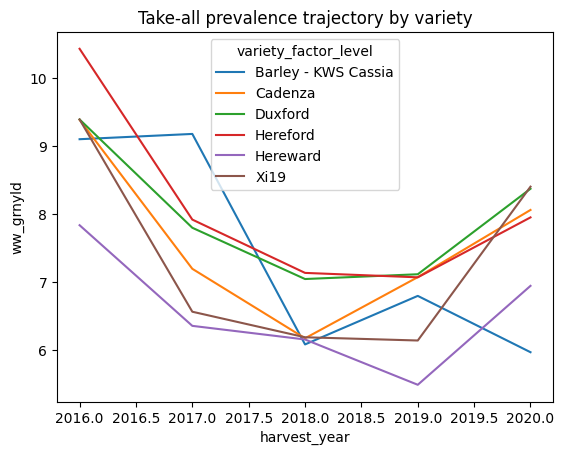

In [2]:
### AIM ###
#What is the threshold that the yield starts to decline significantly?
#Create line plot for grain yield and harvest_year using concatenated yield_760 worksheet

### PROCESS ###
yield_760 = pd.read_excel('yield_760.xlsx')
yield_760['harvest_year'] = pd.to_datetime(yield_760['harvest_year']).dt.year
data_y = yield_760.copy()
data_y = data_y.groupby(['harvest_year', 'variety_factor_level'])[['ww_grnyld', 'ww_stryld', 'ww_grn_str_ratio']].mean().reset_index()

sns.lineplot(data = data_y, x = "harvest_year", y = "ww_grnyld", hue = "variety_factor_level", estimator = "mean")
plt.title("Take-all prevalence trajectory by variety")
plt.show()

In [3]:
### AIM ###
#Feature engineering: Making the root and plant infected percent
#Grouping the features by harvest_year and wheat variety and finding the mean

### PROCESS ###
all_760 = pd.read_excel('760_all.xlsx')
data_x = all_760.copy()
data_x['root_pct'] = data_x['ww_rts_tkal_cnt'] / data_x['ww_rts_cnt']
data_x['plant_pct'] = data_x['ww_pla_tkal_cnt'] / data_x['ww_pla_cnt']
data_x = data_x.groupby(['harvest_year', 'variety_factor_level'])[['root_pct', 'plant_pct', 'pla_height']].mean().reset_index()

C:\Users\jackm\AppData\Local\Temp\ipykernel_3940\3452628058.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data = total_xy, x = 'variety_factor_level', y = 'root_pct', jitter = True, size = 5, alpha = 0.75, palette = 'magma')


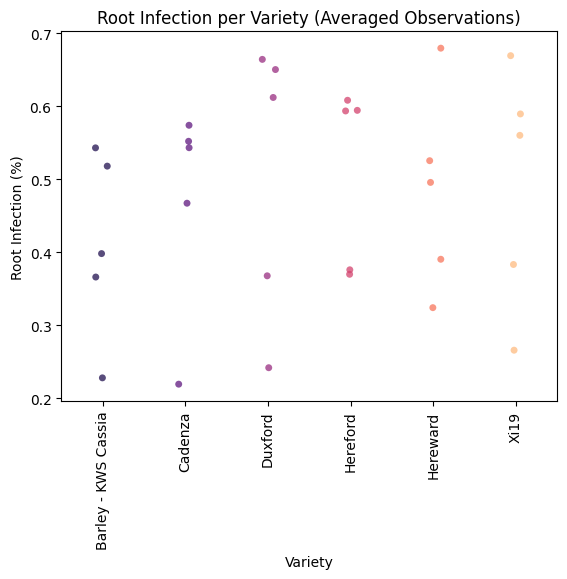

In [6]:
### AIM ###
#Merging both plant takeall buildup data and yield output
#Data were aggregated by mean for harvest year and wheat variety before merging
#Aggregated merging was used because both tables had varied sample sizes

### PROCESS ###
total_xy = pd.merge(data_x, data_y, on = ['harvest_year', 'variety_factor_level'], how = 'left')
total_xy = total_xy.sort_values(by = ['variety_factor_level', 'harvest_year'],  ascending = [True, True]).reset_index(drop = True)

#Using the strip plot to observe the distribution of aggregated yield values for plant varieties for years (2016-2020). Years not labeled

sns.stripplot(data = total_xy, x = 'variety_factor_level', y = 'root_pct', jitter = True, size = 5, alpha = 0.75, palette = 'magma')
plt.xticks(rotation = 90)
plt.title("Root Infection per Variety (Averaged Observations)")
plt.xlabel("Variety")
plt.ylabel("Root Infection (%)")
plt.show()

### RESULTS ###
#Larger gaps exist between Duxford and Cadenza, suggesting greater increase in takeall severity
#Hereward and Xi19 are more dispersed, suggesting the buildup of intensity is more gradual

<Axes: >

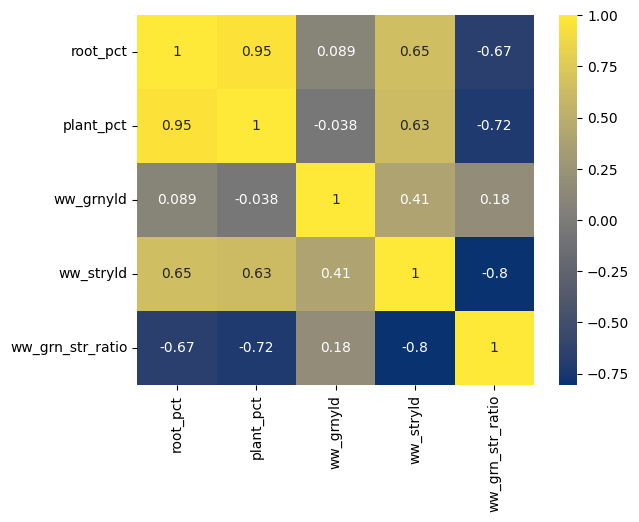

In [7]:
### AIM ###
#Aggregated table (mean values for each variety of each year for plant features) used to make correlation plot

### PROCESS ###
time_xy = total_xy.copy()
time_xy = time_xy[time_xy['harvest_year'].between(2016, 2020)]
sns.heatmap(time_xy[['root_pct','plant_pct','ww_grnyld','ww_stryld','ww_grn_str_ratio']].corr(), annot = True, cmap = 'cividis', center = 0)

In [8]:
### AIM ###
#Interactive plot to single out variety type for take all yield between 2016-2020

### PROCESS ###
fig = px.line(total_xy[total_xy['harvest_year'].between(2016, 2019)], x = 'root_pct', y = 'ww_grnyld', color = 'variety_factor_level', title = 'Grain Yield Over Time by Variety',
    labels = {'harvest_year': 'Harvest Year', 'ww_grnyld': 'Yield (t/ha)', 'variety_factor_level': 'Variety Type'})

fig.update_layout(legend = dict(title = 'Variety Type', x=1, y = 1), template = 'plotly_dark')
fig.show()

fig2 = px.scatter(total_xy, x = 'harvest_year', y = 'root_pct', color = 'variety_factor_level', title = 'Grain Yield Over Time by Variety',
    labels = {'harvest_year': 'Harvest Year', 'ww_grnyld': 'Yield (t/ha)', 'variety_factor_level': 'Variety Type'})
fig2.update_layout(legend = dict(title = 'Variety Type', x = 1, y = 1), template = 'plotly_dark')
fig2.show()


fig3 = px.line(total_xy[total_xy['harvest_year'].between(2016, 2019)], x='harvest_year', y = 'ww_grn_str_ratio', color = 'variety_factor_level', title = 'Grain Yield Over Time by Variety',
    labels = {'harvest_year': 'Harvest Year', 'ww_grnyld': 'Yield (t/ha)', 'variety_factor_level': 'Variety Type'})

fig3.update_layout(legend=dict(title = 'Variety Type', x = 1, y = 1), template = 'plotly_dark')
fig3.show()

In [9]:
### AIM ###
#Correlation between yield and infection severity for each variety
#This is meant to demonstrate which varieties are most impacted by takeall regarding yield

### PROCESS ###
total_xy = total_xy.sort_values(['variety_factor_level', 'harvest_year'])

# Calculate year-to-year change for both infection and yield
# Afterwards, finding the correlation between the two rates

total_xy['plant_change'] = total_xy.groupby('variety_factor_level')['root_pct'].diff()
total_xy['yield_change'] = total_xy.groupby('variety_factor_level')['ww_grnyld'].diff()

#Seperated between early and late periods
#2016-2019 includes an increase in takeall severity and decrease in yield
early_period = total_xy[total_xy['harvest_year'].between(2016, 2019)]

corrs_early = (early_period.groupby('variety_factor_level')[['plant_change', 'yield_change']].corr().iloc[0::2, -1].reset_index())

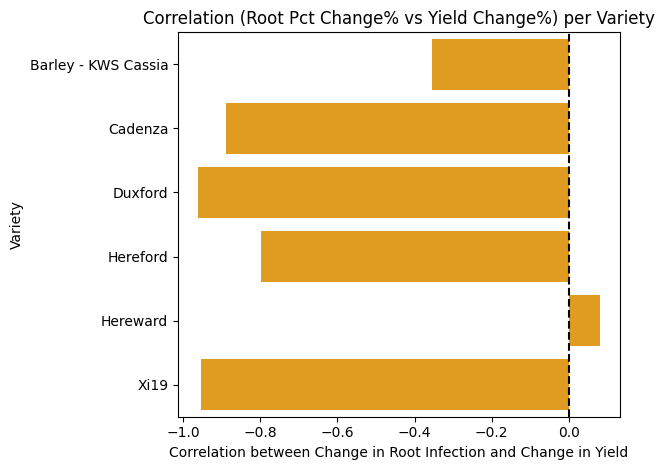

In [10]:
### AIM ###
#Correlation plot between Root Infection and Yield Change

### PROCESS ###
sns.barplot(data = corrs_early, y = 'variety_factor_level', x = 'yield_change', color = 'orange')
plt.axvline(0, color = 'black', linestyle = '--')
plt.title('Correlation (Root Pct Change% vs Yield Change%) per Variety')
plt.xlabel('Correlation between Change in Root Infection and Change in Yield')
plt.ylabel('Variety')
plt.tight_layout()
plt.show()

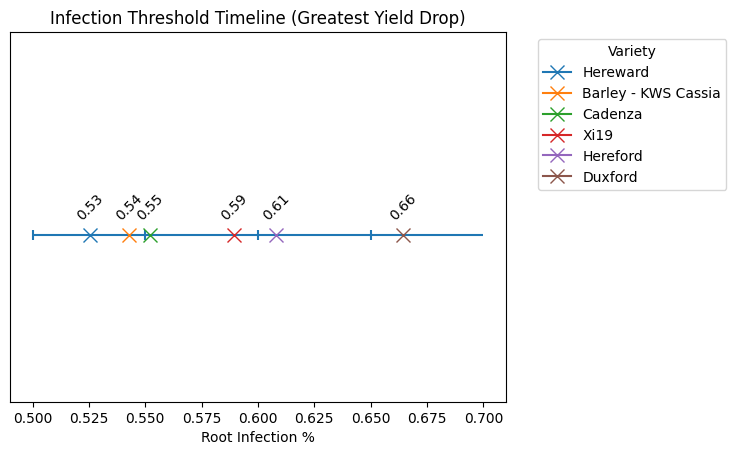

In [11]:
### AIM ###
#Finding the variety's largest drop in yield and identifying the take all intesnity level (root percent infected) which this drop occurred.

### PROCESS ### 
threshold = []

for v, d in time_xy.groupby('variety_factor_level'):
    d = d.sort_values('root_pct')
    #Finding the largest slope drop
    dy_dx = np.diff(d['ww_grnyld']) / np.diff(d['root_pct'])
    #Finds the steepest negative slope
    drop_id = np.argmin(dy_dx)
    threshold.append((v, d['root_pct'].iloc[drop_id + 1]))

threshold_values = pd.DataFrame(threshold, columns = ['Variety', 'Approx_Threshold_%']).sort_values(by = 'Approx_Threshold_%').reset_index(drop = True)
plt.hlines(y = 0, xmin = 0.5, xmax = 0.7)

#Creates vertical lines that are evenly placed every 0.05
for val in np.arange(0.5, 0.7, 0.05):
    plt.vlines(x = val, ymin = -0.01, ymax = 0.01)

#Plotting the threshold values for each variety on the severity scale between 0.5 and 0.7
for j, k in threshold_values.iterrows():
    x = k['Approx_Threshold_%']
    variety = k['Variety']
    plt.plot(x, 0, marker = 'x', label = variety, markersize = 10)
    plt.text(x, 0.03, f"{x:.2f}", ha = 'center', rotation = 45)

#Plotting model
plt.legend(title = "Variety", bbox_to_anchor = (1.05, 1), loc = "upper left")
plt.ylim(-0.33, 0.4)
plt.yticks([])
plt.xlabel("Root Infection %")
plt.title("Infection Threshold Timeline (Greatest Yield Drop)")
plt.show()

### RESULTS ###
#Duxford had the latest drop off at 66%
#Hereward had the earliest drop off at 53%

In [12]:
### AIM ###
#Mean of reponse values per variety per year

### PROCESS ###
yield_group = yield_760.groupby(['harvest_year','variety_factor_level'])[['ww_grnyld', 'ww_stryld', 'ww_grn_str_ratio']].mean().reset_index()
yield_group = yield_group.sort_values(by = ['variety_factor_level', 'harvest_year']).reset_index(drop = True)
yield_760 = yield_760.sort_values(by = ['variety_factor_level', 'harvest_year']).reset_index(drop = True)

In [13]:
### AIM ###
#Infection counts were averaged over sets of 5. These averaged values were index matched with yield data for the merge table

### PROCESS ###
all_760 = pd.read_excel('760_all.xlsx')
all_760 = all_760.sort_values(by = ['harvest_year', 'variety_factor_level']).reset_index()
all_760['roots_pct'] = all_760['ww_rts_tkal_cnt'] / all_760['ww_rts_cnt']
means = all_760['roots_pct'].groupby(all_760.index // 5).mean().reset_index(drop = True)
total_760 = pd.merge(yield_760, means, left_index = True, right_index = True, how = 'inner')
total_760 = total_760.dropna()

<Figure size 1000x600 with 0 Axes>

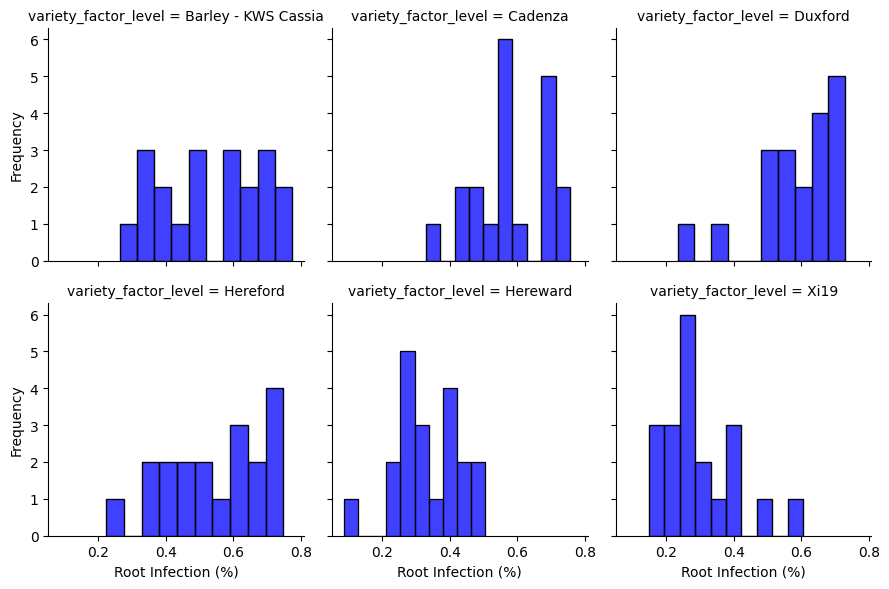

In [14]:
### AIM ###
#Distribution of root percentage infected observations for each variety type

### PROCESS ###
plt.figure(figsize = (10, 6))
g = sns.FacetGrid(total_760, col = "variety_factor_level", col_wrap = 3, height = 3)
g.map(sns.histplot, "roots_pct", bins = 10, color = "blue")
g.set_axis_labels("Root Infection (%)", "Frequency")
plt.tight_layout()
plt.show()

### RESULTS ###
#Distributions are either approximately normal distributed or skewed

In [15]:
### AIM ###
#Observing any prominant outliers 

### PROCESS ###
z = np.abs(zscore(total_760[['ww_grn_str_ratio', 'roots_pct']]))
outliers = total_760[(z > 3).any(axis=1)]
outliers

Q1 = total_760['ww_grn_str_ratio'].quantile(0.20)
Q3 = total_760['ww_grn_str_ratio'].quantile(0.80)
IQR = Q3 - Q1

outliers = total_760[(total_760['ww_grn_str_ratio'] < Q1 - (1.5*IQR)) | (total_760['ww_grn_str_ratio'] > Q3 + (1.5*IQR))]

outliers

### RESULTS ###
#Only two present major outliers, no issue on SVR model

,harvest_year,variety_factor_level,ww_grnyld,ww_stryld,ww_grn_str_ratio,roots_pct
56,2020,Duxford,8.000,1.606,4.9813,0.564665
98,2020,Hereward,4.777,0.911,5.2437,0.251886


In [16]:
### AIM ###
#Creating the SVR Model and recording the average residual

### PROCESS ###
X_val = total_760[['roots_pct']]
y_val = total_760['ww_grnyld']

#Train/Testing/Scaling data
#Creates a nonlinear boundary, a radial basis, to find a nonlinear pattern between root percent infected and grain yield
X_train, X_test, y_train, y_test = train_test_split(X_val, y_val, test_size=0.20, random_state=20)
pipeline = make_pipeline(StandardScaler(), SVR(kernel = 'rbf', C = 1, gamma = 'scale'))
pipeline.fit(X_train, y_train)

total_760['predicted'] = pipeline.predict(X_val)
total_760['resid'] = total_760['ww_grnyld'] - total_760['predicted']

sus_index = (total_760.groupby('variety_factor_level')['resid'].mean().sort_values(ascending = True))
print(sus_index)

### RESULTS ###
#Negative values means the residual is negative and the yield is lower than predicted
#Positive values means the residual is positive and the yield is higher than predicted

variety_factor_level
Hereward              -1.124031
Xi19                  -0.589293
Barley - KWS Cassia    0.000091
Cadenza                0.262002
Duxford                0.691340
Hereford               0.807812
Name: resid, dtype: float64


C:\Users\jackm\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



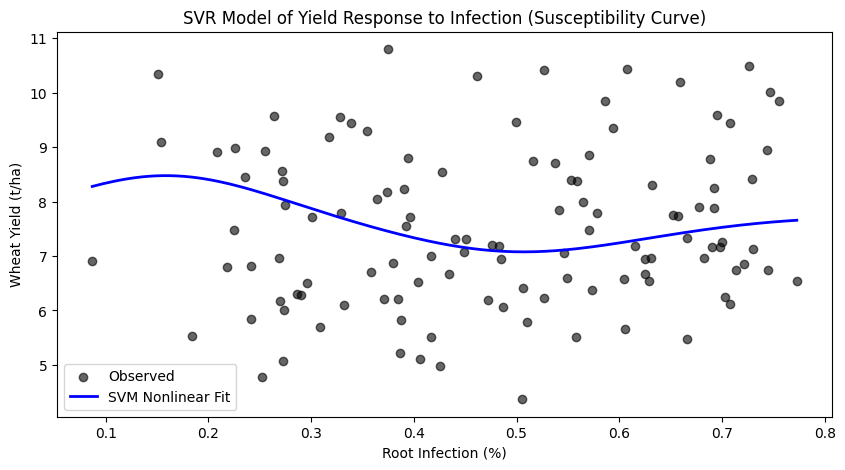

In [17]:
### SVR Model plot ###
plt.figure(figsize = (10,5))
X_range = np.linspace(X_val.min(), X_val.max(), 200).reshape(-1, 1)
y_pred = pipeline.predict(X_range)

plt.scatter(X_val, y_val, color = 'black', alpha=0.6, label='Observed')
plt.plot(X_range, y_pred, color = 'blue', linewidth=2, label='SVM Nonlinear Fit')
plt.xlabel("Root Infection (%)")
plt.ylabel("Wheat Yield (t/ha)")
plt.title("SVR Model of Yield Response to Infection (Susceptibility Curve)")
plt.legend()
plt.show()

### PROCESS ###
#Shows that yield limiting point exists between 0.3 and 0.5. Any percentage afterwards doesn't display as much dramatic yield loss. 